In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from module import FlowMatchingModel 
import random

In [2]:
import Pk_library as PKL
def get_pk(mat):
    BoxSize = 25.0    
    MAS     = 'None'  
    threads = 1       
    pk = PKL.Pk_plane(mat,BoxSize,MAS,threads,verbose=False)
    return pk.k, pk.Pk

Normalising tot log maps, mean: 25.159475326538086, std: 0.8962634205818176
Normalising star log maps, mean: 0.10909812152385712, std: 1.5765557289123535
Normalising gas log maps, mean: 24.366243362426758, std: 0.8754326105117798


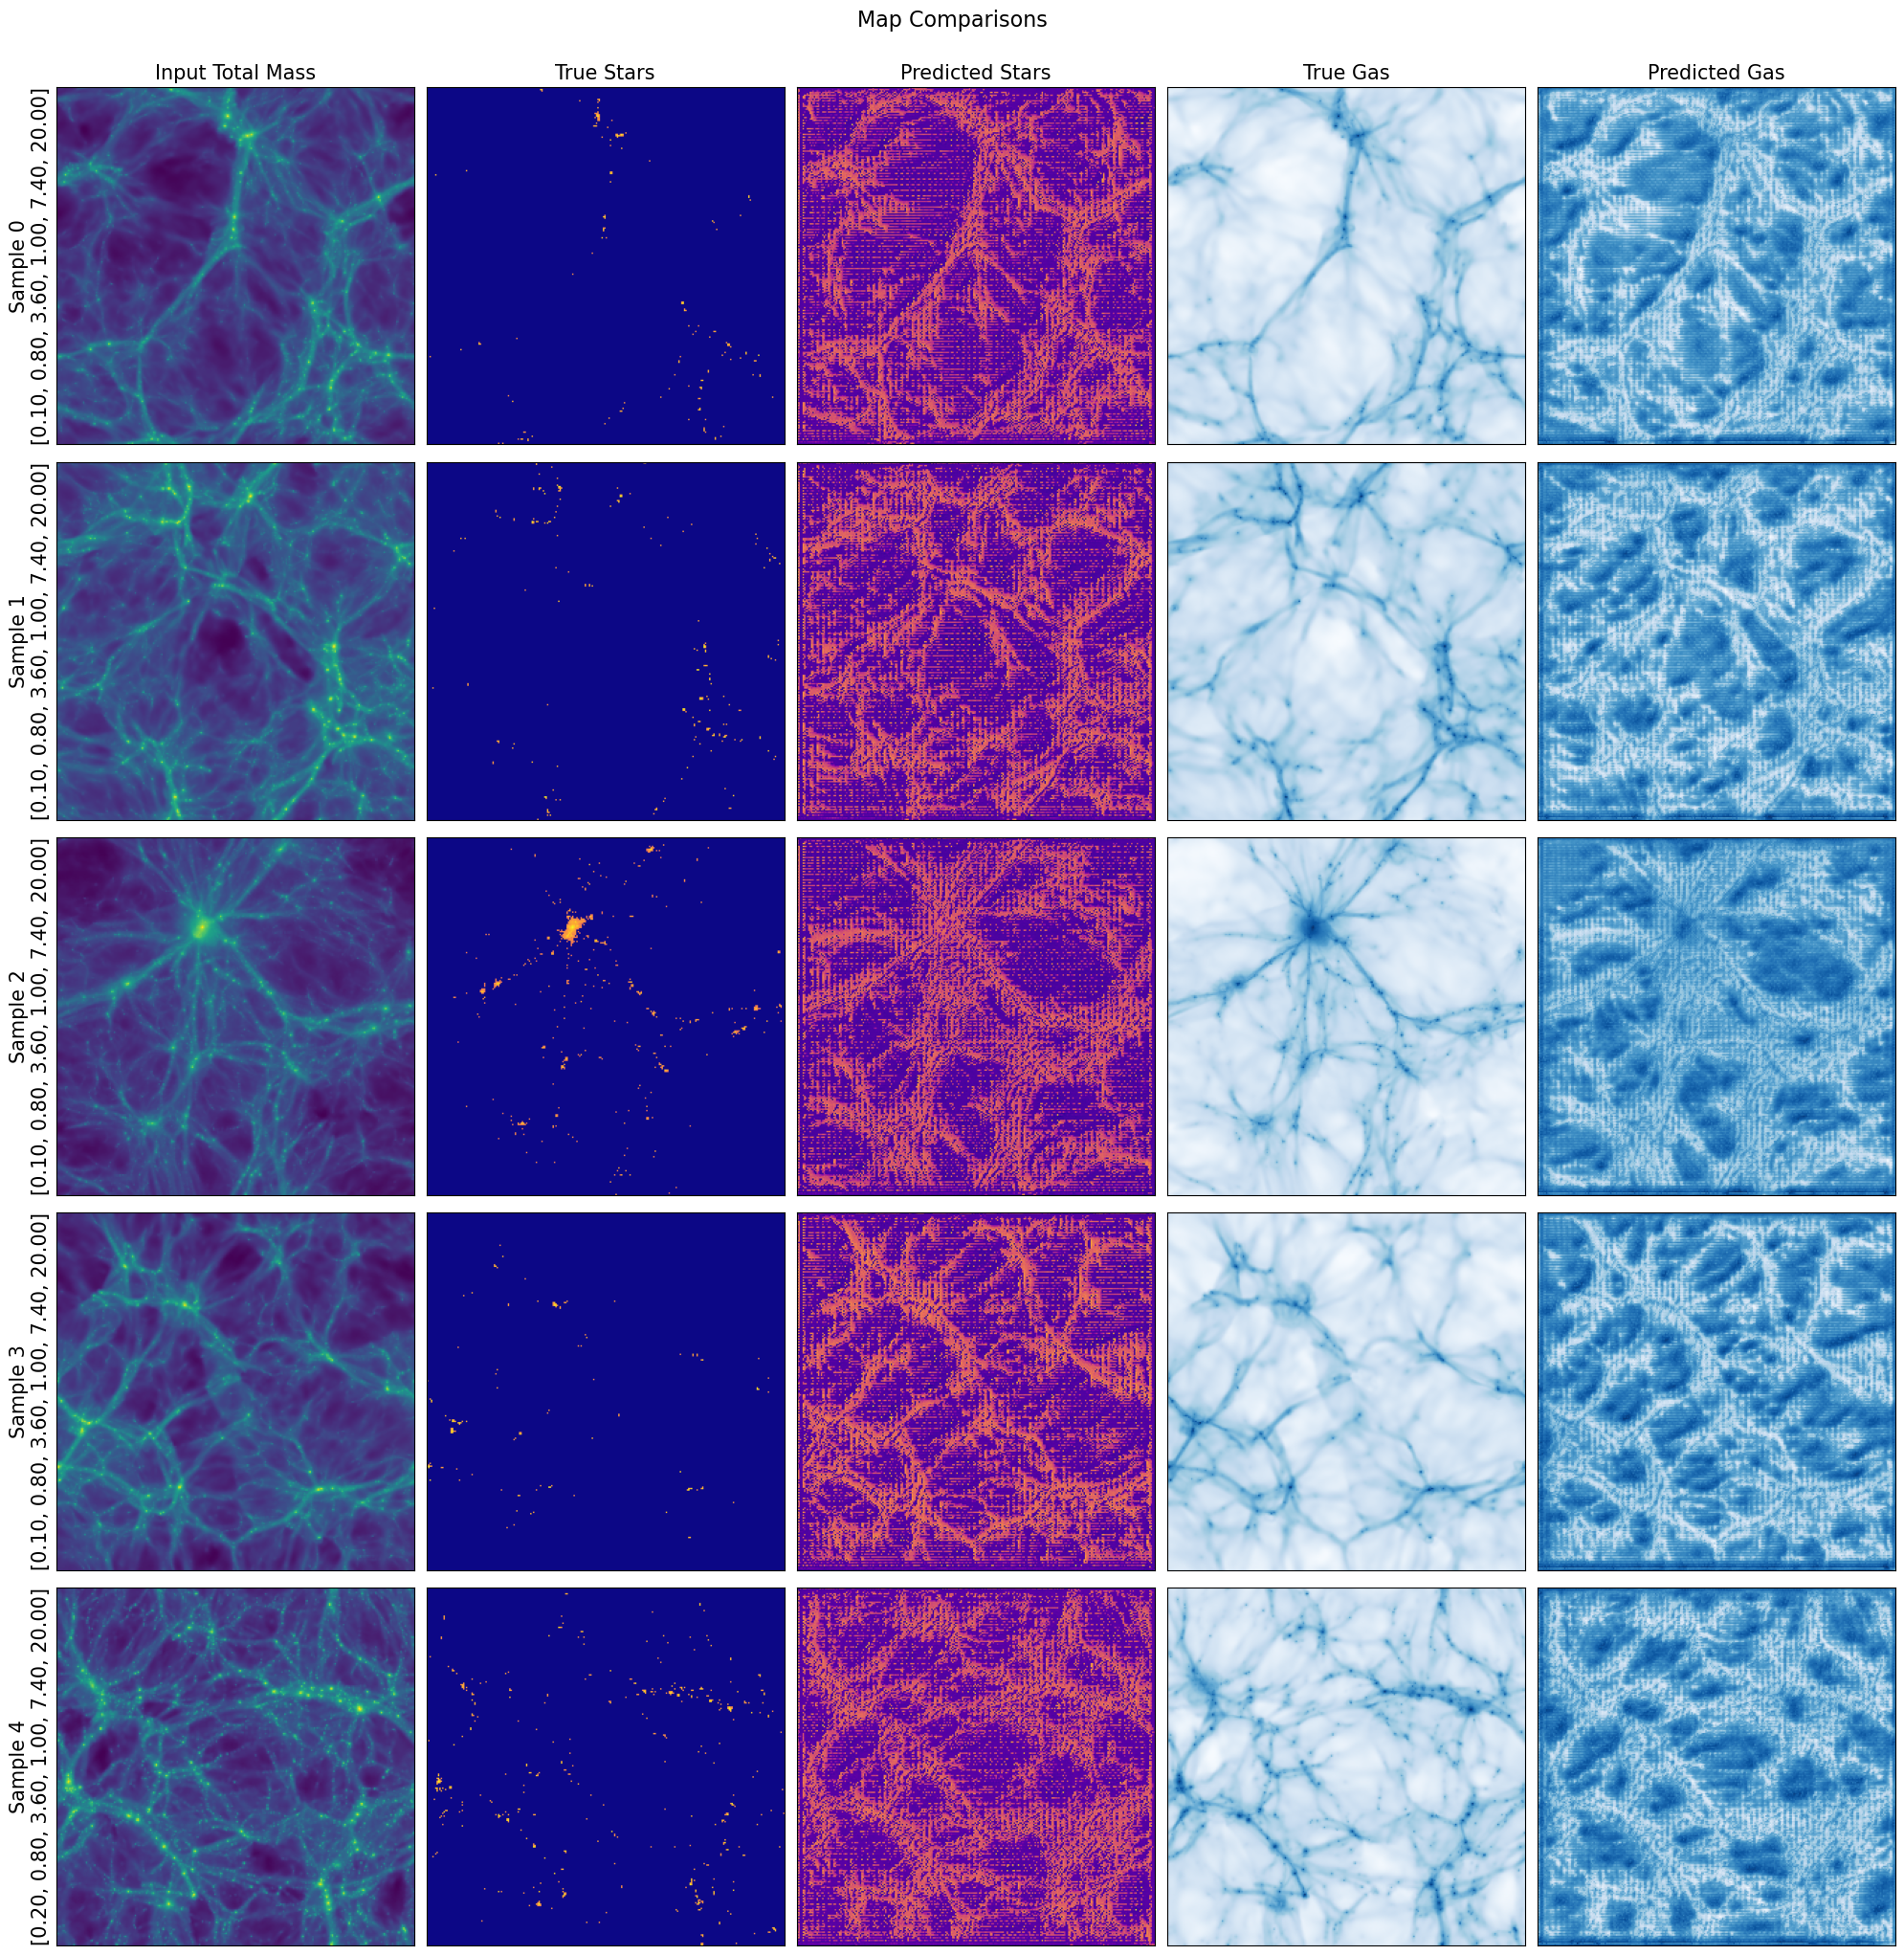

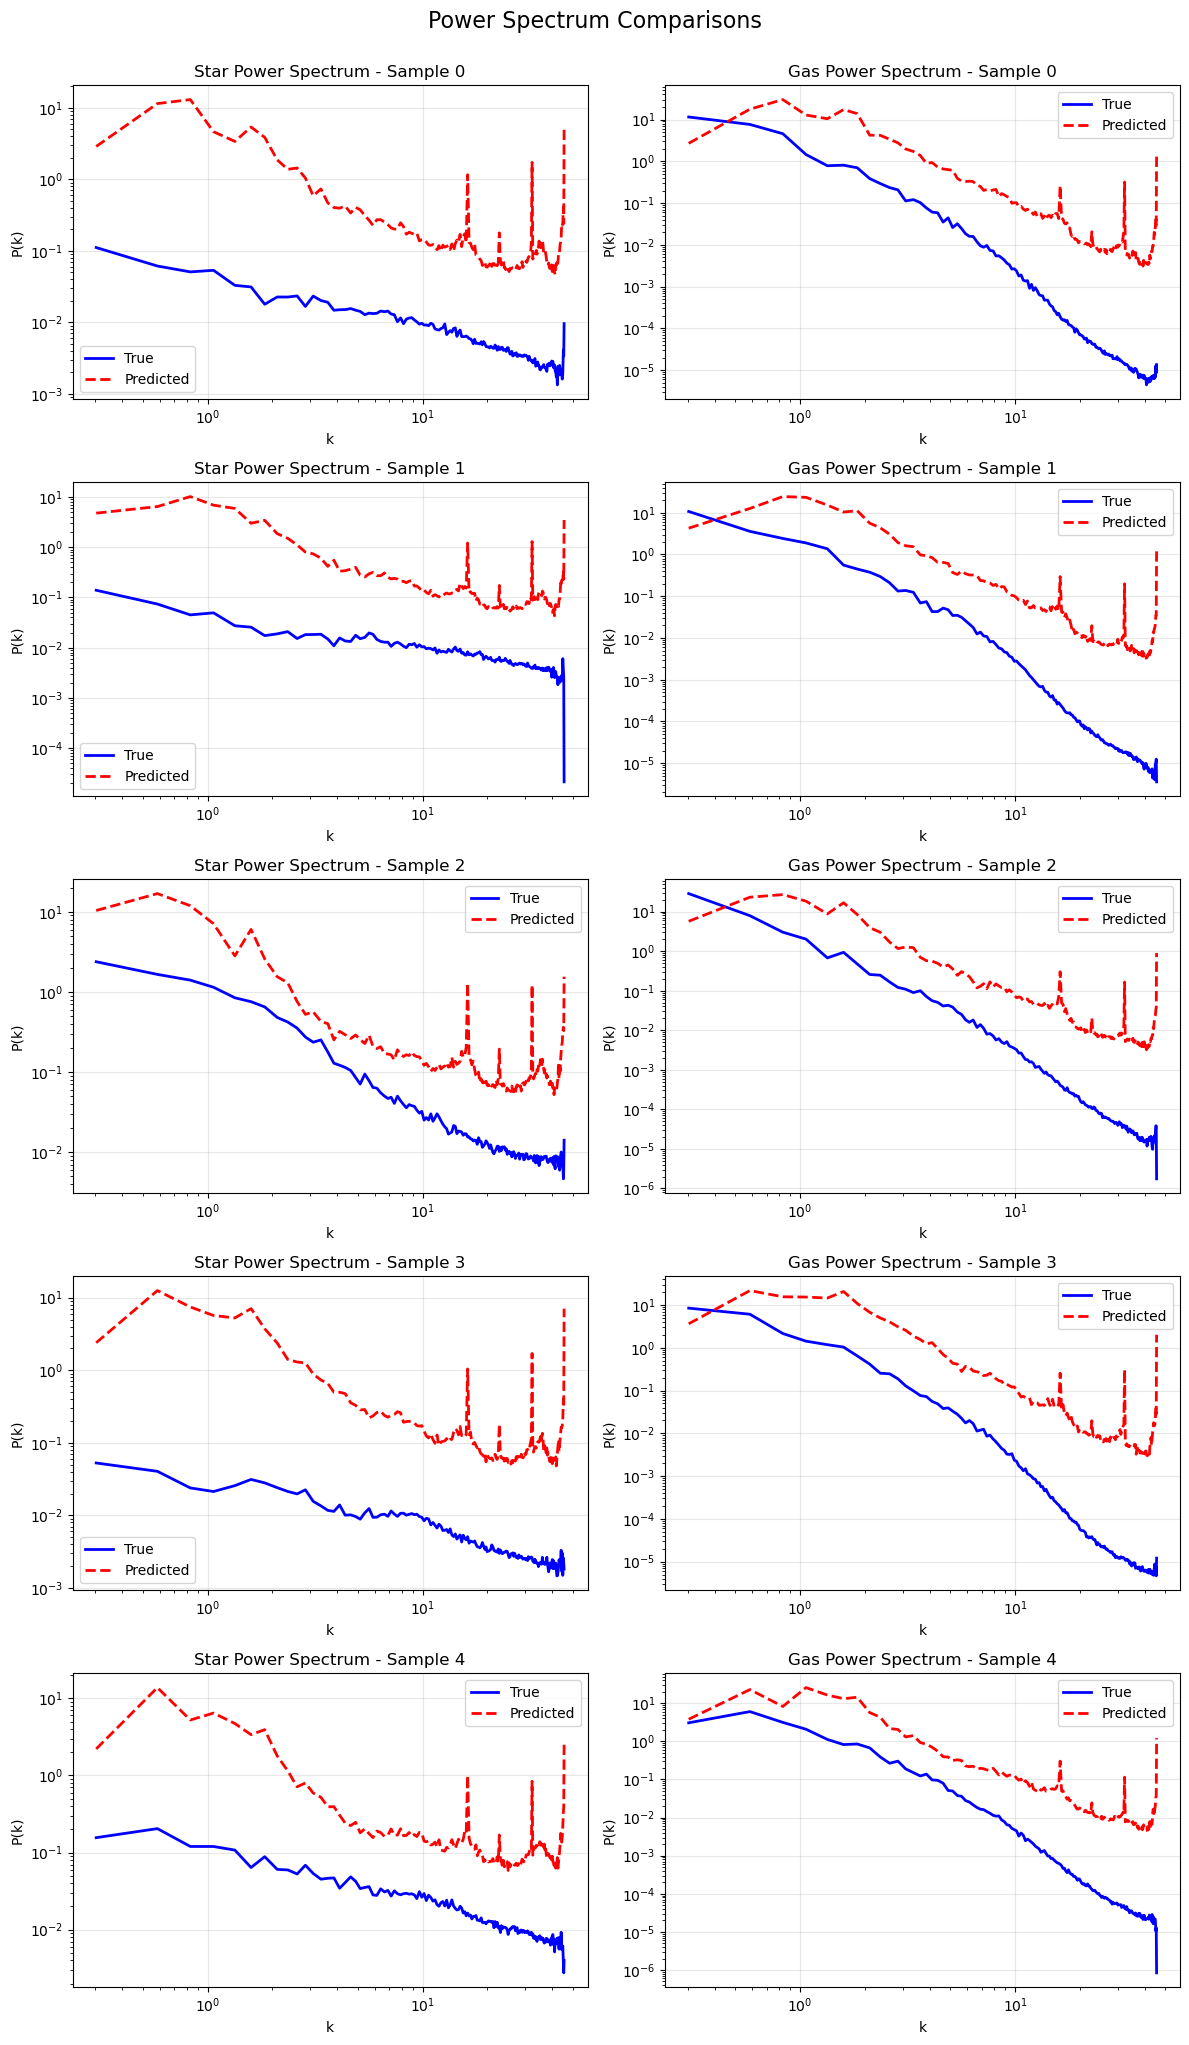

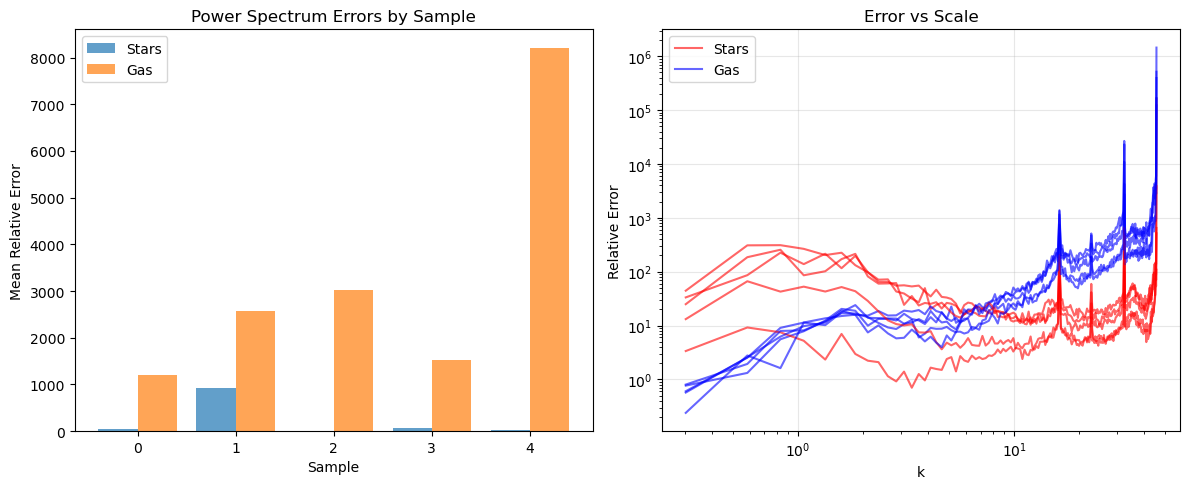

In [30]:
def load_model(checkpoint_path):
    """Load trained flow matching model from checkpoint"""
    from module import FlowMatchingModel
    model = FlowMatchingModel.load_from_checkpoint(checkpoint_path)
    model.eval()
    return model

# Five sample analysis and visualization
def analyze_five_samples(checkpoint_path, total_mass_path, star_maps_path, gas_maps_path, params_path, num_steps=50):
    """Process 5 samples and create comprehensive visualizations"""
    
    # Load model
    model = load_model(checkpoint_path)
    model.eval()

    # Load data (first 5 samples)
    total_mass_maps = np.load(total_mass_path)
    # inds = random.sample(range(len(total_mass_maps)),5)
    inds = random.sample(range(30),5)
    
    total_mass_maps = total_mass_maps[inds]
    star_maps = np.load(star_maps_path)[inds] 
    gas_maps = np.load(gas_maps_path)[inds]
    astro_params = np.loadtxt(params_path)[:,:6]  # First parameter set
    astro_params = np.repeat(astro_params, 15, axis=0)  # Repeat for 15 samples
    astro_params = astro_params[inds]

    
    # Apply log transform
    total_mass_log = np.log1p(total_mass_maps)
    star_maps_log = np.log1p(star_maps)
    gas_maps_log = np.log1p(gas_maps)
    
    # Normalize (use simple normalization)
    tot_mean, tot_std = total_mass_log.mean(), total_mass_log.std()
    total_mass_norm = (total_mass_log - tot_mean) / tot_std

    star_mean, star_std = star_maps_log.mean(), star_maps_log.std()
    star_maps_norm = (star_maps_log - star_mean) / star_std

    gas_mean,gas_std =gas_maps_log.mean(),gas_maps_log.std()
    gas_maps_norm = (gas_maps_log -gas_mean) /gas_std
    
    # Create dataset and dataloader
    from utils import AstroMapDataset
    from torch.utils.data import DataLoader
    
    dataset = AstroMapDataset(total_mass_log, star_maps_log, gas_maps_log, astro_params)
    dataloader = DataLoader(dataset, batch_size=5, shuffle=False)
    
    # Generate predictions
    device = next(model.parameters()).device
    with torch.no_grad():
        for batch in dataloader:
            total_mass_batch, _, params_batch = batch
            total_mass_batch = total_mass_batch.to(device)
            params_batch = params_batch.to(device)
            
            predictions = model.sample(
                total_mass=total_mass_batch,
                astro_params=params_batch,
                total_mass_condition=total_mass_batch,
                num_steps=num_steps,
                method='euler'
            )
            predictions = predictions.cpu().numpy()
            break
    
    # Compute power spectra
    star_pk_results = []
    gas_pk_results = []
    
    for i in range(5):
        # Star maps
        k_star_pred, pk_star_pred = get_pk(predictions[i, 0])
        k_star_true, pk_star_true = get_pk(star_maps_norm[i])
        star_pk_results.append({
            'k': k_star_pred,
            'pk_pred': pk_star_pred,
            'pk_true': pk_star_true,
            'error': np.abs(pk_star_pred - pk_star_true) / pk_star_true
        })
        
        # Gas maps  
        k_gas_pred, pk_gas_pred = get_pk(predictions[i, 1])
        k_gas_true, pk_gas_true = get_pk(gas_maps_norm[i])
        gas_pk_results.append({
            'k': k_gas_pred,
            'pk_pred': pk_gas_pred,
            'pk_true': pk_gas_true,
            'error': np.abs(pk_gas_pred - pk_gas_true) / pk_gas_true
        })
    
    # Create visualizations
    plot_five_samples(total_mass_norm, predictions, star_maps_norm, gas_maps_norm, 
                     astro_params, star_pk_results, gas_pk_results)
    
    return predictions, star_pk_results, gas_pk_results

def plot_five_samples(total_mass, predictions, true_star_maps, true_gas_maps, 
                     astro_params, star_pk_results, gas_pk_results):
    """Create comprehensive plots for 5 samples"""
    
    # 1. Map comparison grid
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    
    for i in range(5):
        # Input total mass
        im0 = axes[i,0].imshow(total_mass[i], cmap='viridis')
        axes[i,0].set_title('Input Total Mass' if i==0 else '', fontsize=15)
        
        # True star
        im1 = axes[i,1].imshow(true_star_maps[i], cmap='plasma')
        axes[i,1].set_title('True Stars' if i==0 else '', fontsize=15)
        
        # Predicted star  
        im2 = axes[i,2].imshow(predictions[i,0], cmap='plasma')
        axes[i,2].set_title('Predicted Stars' if i==0 else '', fontsize=15)
        
        # True gas
        im3 = axes[i,3].imshow(true_gas_maps[i], cmap='Blues')
        axes[i,3].set_title('True Gas' if i==0 else '', fontsize=15)
        
        # Predicted gas
        im4 = axes[i,4].imshow(predictions[i,1], cmap='Blues')
        axes[i,4].set_title('Predicted Gas' if i==0 else '', fontsize=15)
        
        # Remove ticks
        for ax in axes[i]:
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Add parameter info
        param_str = f"Sample {i}\n[{', '.join(f'{p:.2f}' for p in astro_params[i])}]"
        axes[i,0].set_ylabel(param_str, fontsize=15)
    
    plt.tight_layout()
    plt.suptitle('Map Comparisons', fontsize=16, y=1.02)
    plt.savefig('grid.png')
    plt.show()
    
    # 2. Power spectrum comparisons
    fig, axes = plt.subplots(5, 2, figsize=(12, 20))
    
    for i in range(5):
        # Star power spectra
        axes[i,0].loglog(star_pk_results[i]['k'], star_pk_results[i]['pk_true'], 
                        'b-', label='True', linewidth=2)
        axes[i,0].loglog(star_pk_results[i]['k'], star_pk_results[i]['pk_pred'], 
                        'r--', label='Predicted', linewidth=2)
        axes[i,0].set_title(f'Star Power Spectrum - Sample {i}')
        axes[i,0].set_xlabel('k')
        axes[i,0].set_ylabel('P(k)')
        axes[i,0].legend()
        axes[i,0].grid(True, alpha=0.3)
        
        # Gas power spectra
        axes[i,1].loglog(gas_pk_results[i]['k'], gas_pk_results[i]['pk_true'], 
                        'b-', label='True', linewidth=2)
        axes[i,1].loglog(gas_pk_results[i]['k'], gas_pk_results[i]['pk_pred'], 
                        'r--', label='Predicted', linewidth=2)
        axes[i,1].set_title(f'Gas Power Spectrum - Sample {i}')
        axes[i,1].set_xlabel('k')
        axes[i,1].set_ylabel('P(k)')
        axes[i,1].legend()
        axes[i,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Power Spectrum Comparisons', fontsize=16, y=1.02)
    plt.savefig('pk.png')
    plt.show()
    
    # 3. Error summary
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Mean errors per sample
    star_mean_errors = [np.mean(result['error']) for result in star_pk_results]
    gas_mean_errors = [np.mean(result['error']) for result in gas_pk_results]
    
    x = range(5)
    ax1.bar([i-0.2 for i in x], star_mean_errors, 0.4, label='Stars', alpha=0.7)
    ax1.bar([i+0.2 for i in x], gas_mean_errors, 0.4, label='Gas', alpha=0.7)
    ax1.set_xlabel('Sample')
    ax1.set_ylabel('Mean Relative Error')
    ax1.set_title('Power Spectrum Errors by Sample')
    ax1.legend()
    ax1.set_xticks(x)
    
    # Error vs k for all samples
    for i in range(5):
        ax2.loglog(star_pk_results[i]['k'], star_pk_results[i]['error'], 
                  'r-', alpha=0.6, label='Stars' if i==0 else '')
        ax2.loglog(gas_pk_results[i]['k'], gas_pk_results[i]['error'], 
                  'b-', alpha=0.6, label='Gas' if i==0 else '')
    
    ax2.set_xlabel('k')
    ax2.set_ylabel('Relative Error')
    ax2.set_title('Error vs Scale')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
# Usage
predictions, star_results, gas_results = analyze_five_samples(
    checkpoint_path='/n/netscratch/iaifi_lab/Lab/msliu/flow_COND/lightning_logs/tng_cosmo_cond/checkpoints/best-model-epoch=155-val_loss=0.001330.ckpt',
    total_mass_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_1P_z=0.00.npy',
    star_maps_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mstar_IllustrisTNG_1P_z=0.00.npy',
    gas_maps_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mgas_IllustrisTNG_1P_z=0.00.npy',
    params_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/params_1P_IllustrisTNG.txt',
    num_steps=50
)

In [16]:
params_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/params_1P_IllustrisTNG.txt',
check = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_SB28_z=0.00.npy')
check.shape

(30720, 256, 256)

In [20]:
len(check)

30720

In [7]:
PARAM1P = np.loadtxt('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/params_1P_IllustrisTNG.txt')
PARAMLH = np.loadtxt('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/params_LH_IllustrisTNG.txt')


In [12]:
p = PARAM1P
q = PARAMLH

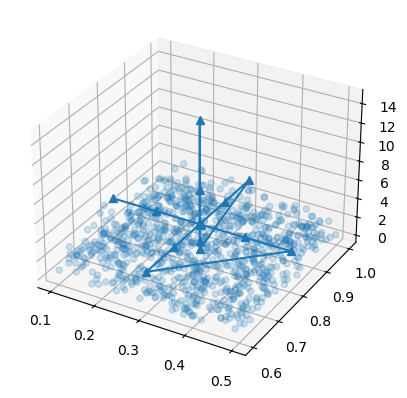

In [36]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot(p[:,0], p[:,1], p[:,2], marker='^')
ax.scatter(q[:,0], q[:,1], q[:,2], marker='o',alpha=0.2)


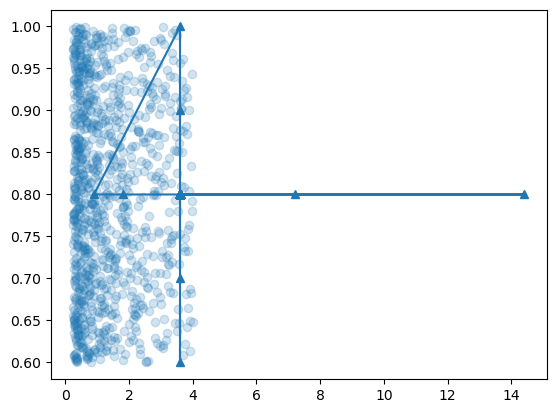

In [43]:
plt.plot(p[:,2], p[:,1], marker='^')
plt.scatter(q[:,2], q[:,1], marker='o',alpha=0.2)

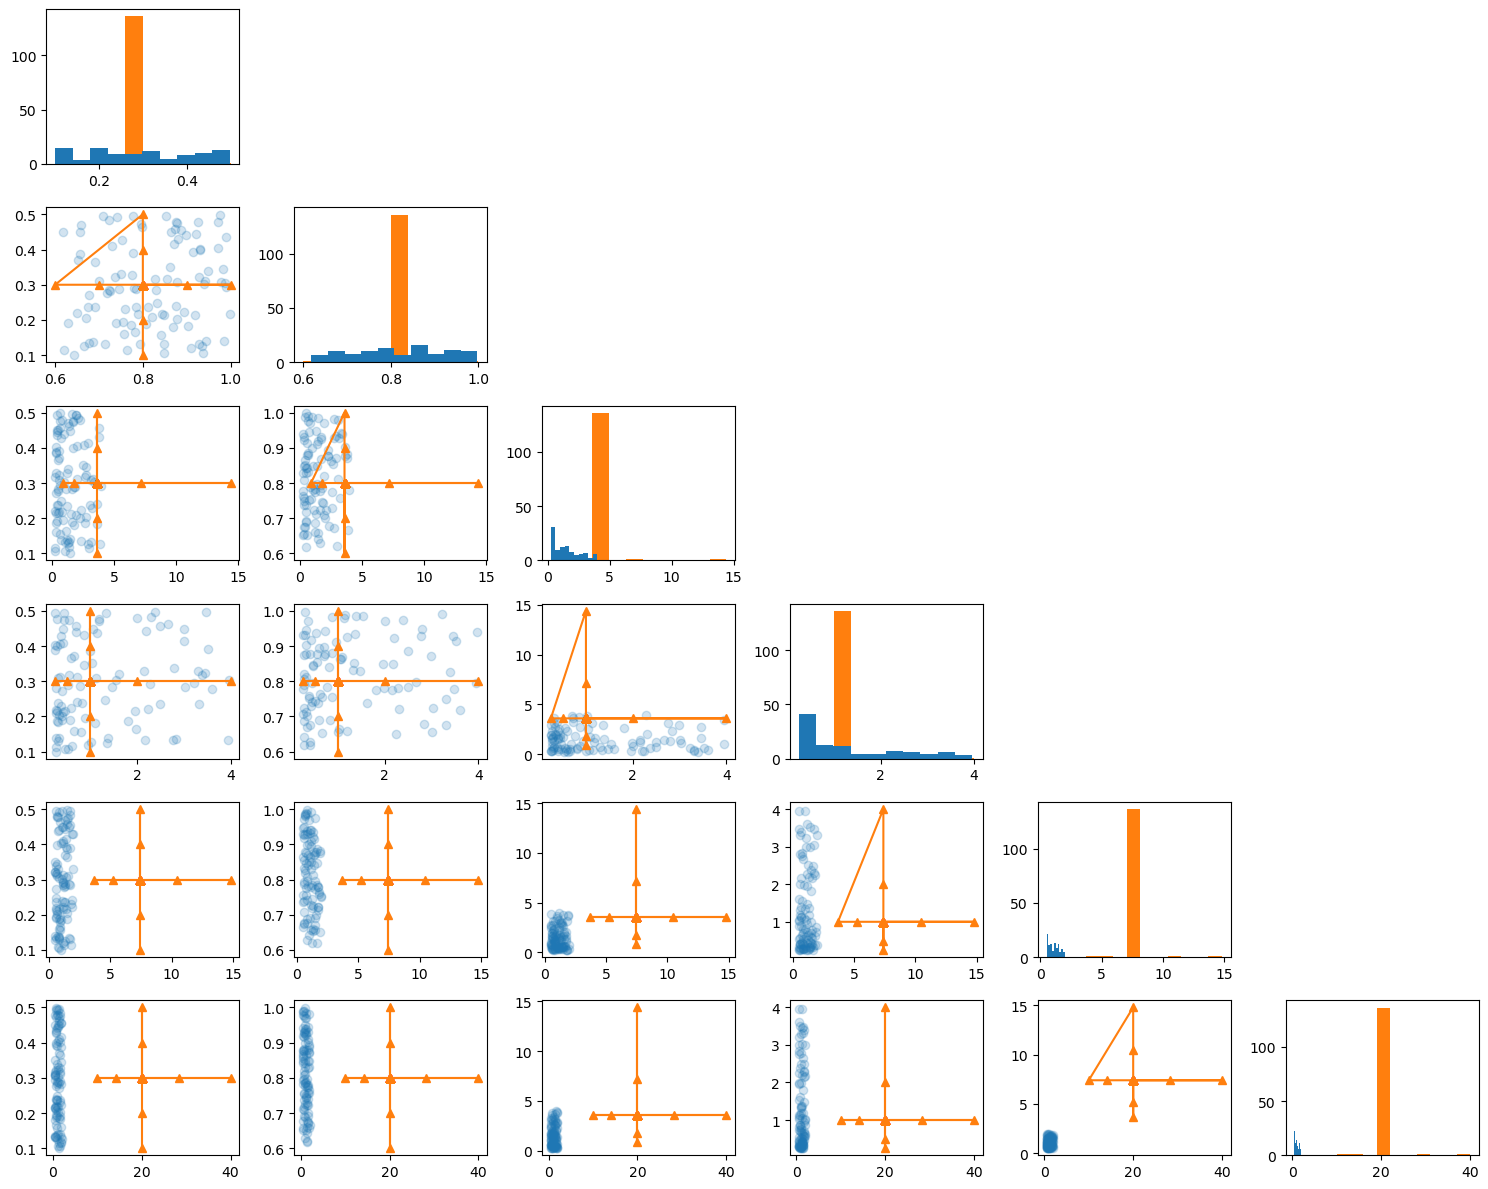

In [13]:
plt.figure(figsize=(15,12))

for i in range(6):
    for j in range(6):
        if i==j:
            plt.subplot(6,6,i*6+j+1)
            plt.hist(p[:,i],color='tab:orange')
            plt.hist(q[:,j])
        if i>j:
            plt.subplot(6,6,i*6+j+1)
            plt.plot(p[:,i], p[:,j], marker='^', color='tab:orange')
            plt.scatter(q[:,i], q[:,j], marker='o',alpha=0.2)
plt.tight_layout()
plt.savefig('param_comp.png')
plt.show()

In [54]:
plt.figure(figsize=(15,12))

for i in range(6):
    for j in range(6):
        if i==j:
            plt.subplot(6,6,i*6+j+1)
            plt.hist(p[:,i],color='tab:orange')
            plt.hist(q[:,j])
        if i>j:
            plt.subplot(6,6,i*6+j+1)
            plt.plot(p[:,i], p[:,j], marker='^', color='tab:orange')
            plt.scatter(q[:,i], q[:,j], marker='o',alpha=0.2)
plt.tight_layout()
plt.savefig('param_comp.png')
plt.show()

array([[ 0.1,  0.8,  3.6,  1. ,  7.4, 20. ],
       [ 0.2,  0.8,  3.6,  1. ,  7.4, 20. ],
       [ 0.3,  0.8,  3.6,  1. ,  7.4, 20. ],
       [ 0.4,  0.8,  3.6,  1. ,  7.4, 20. ],
       [ 0.5,  0.8,  3.6,  1. ,  7.4, 20. ]])

In [25]:
for i in range(28):
    print(PARAM1P[:,i].min(), PARAMSB28[:,i].min(), PARAM1P[:,i].max(), PARAMSB28[:,i].max())


0.1 0.10007 0.5 0.49984
0.6 0.60004 1.0 0.99981
0.9 0.90025 14.4 14.3972
0.25 0.25005 4.0 3.99657
3.7 3.70185 14.8 14.7915
10.0 10.0011 40.0 39.9821
0.029 0.02901 0.069 0.069
0.4711 0.47122 0.8711 0.87108
0.7624 0.76248 1.162 1.1622
1.135 1.13553 4.54 4.5375
0.1 0.10007 0.9 0.89985
-2.8 -2.79961 -1.8 -1.80036
4.0 4.00362 12.0 11.9976
0.025 0.02503 0.4 0.39965
0.0 0.596 4000.0 3998.18994
0.005 0.00501 0.5 0.49919
150.0 150.116 550.0 549.93298
0.0625 0.06258 1.0 0.99873
0.0005 0.0005 0.008 0.00799
1.0 1.00038 3.0 2.99927
0.2 0.20003 1.0 0.9997
3e-05 3e-05 0.00025 0.00025
0.25 0.25026 4.0 3.99925
0.1 0.10016 10.0 9.9994
0.025 0.02501 0.4 0.39981
0.05 0.05001 0.8 0.79902
6e-05 6e-05 0.0632 0.0632
0.0 0.00168 4.0 3.99836


In [21]:
for i in [0,1,3,22]:
    print(PARAM1P[:,i].min(), PARAM1P[:,i].max())


0.1 0.5
0.6 1.0
0.25 4.0
0.25 4.0


In [22]:
PARAM1P = np.loadtxt('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/params_1P_IllustrisTNG.txt')
PARAMSB28 = np.loadtxt('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/params_SB28_IllustrisTNG.txt')


In [ ]:
for i in [0,1,3,22]:
    print(PARAM1P[:,i].min(), PARAM1P[:,i].max())
